In [ ]:
!pip install langchain_community langchain_core beautifulsoup4 langgraph langchain_ollama chromadb --break-system-packages

In [1]:
import re
import numpy as np
import requests
from langchain_core.tools import tool
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
import os

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Define path for storing ChromaDB
CHROMA_PERSIST_DIRECTORY = "chroma_store"
COLLECTION_NAME = "mtl_documents"

In [3]:
# Keep your original VectorStoreRetriever as a wrapper for ChromaDB
class VectorStoreRetriever:
    def __init__(self, chroma_db):
        self._chroma_db = chroma_db
    
    @classmethod
    def from_docs(cls, docs):
        # Initialize embedding model
        embed_model = OllamaEmbeddings(model="nomic-embed-text")
        
        # Create a new ChromaDB instance
        db = Chroma.from_documents(
            documents=docs,
            embedding=embed_model,
            collection_name=COLLECTION_NAME,
            persist_directory=CHROMA_PERSIST_DIRECTORY
        )
        
        # Persist to disk
        db.persist()
        print(f"Created and saved vector store to {CHROMA_PERSIST_DIRECTORY}")
        
        return cls(db)
    
    def query(self, query: str, k: int = 5) -> list[dict]:
        # Query ChromaDB and format results to match your original format
        results = self._chroma_db.similarity_search_with_relevance_scores(query, k=k)
        
        return [
            {
                "page_content": doc.page_content,
                "metadata": doc.metadata,
                "similarity": score
            }
            for doc, score in results
        ]

In [4]:
def create_new_retriever(urls=None, embed_model=None):
    """Helper function to create a new retriever"""
    if embed_model is None:
        embed_model = OllamaEmbeddings(model="nomic-embed-text")
    
    if urls is None:
        # Default URLs from your code
        urls = [
            "https://Manipaltechnologies.com",
            "https://Mpimanipal.com",
            "https://Manipalglobalprintsolutions.com",
            "https://Manipalbusinesssolutions.com",
            "https://Sahibandhu.com",
            "https://Sahibnk.com",
            "https://Crossfraud.com",
            "https://Westtek.info",
            "https://Manipaldigital.info",
            "https://Manipal.digital",
            "https://Primacyind.com",
            "https://Lascenteur.com",
            "https://Booknetz.com",
            "https://Manipalea.com",
            "https://Simplepayfinance.com",
            "https://Techshresta.com",
            "https://Racheme.us"
        ]
    
    loader = WebBaseLoader(urls)
    docs = loader.load()
    print(f"Loaded {len(docs)} documents.")
    
    # Create new retriever using the custom class
    return VectorStoreRetriever.from_docs(docs)

In [5]:
def get_or_create_retriever(urls=None):
    """
    Check if Chroma collection exists and load it, otherwise create a new one.
    
    Args:
        urls: List of URLs to fetch and embed if creating a new collection
        
    Returns:
        VectorStoreRetriever: The custom retriever wrapping ChromaDB
    """
    # Initialize embedding model
    embed_model = OllamaEmbeddings(model="nomic-embed-text")
    
    # Check if the ChromaDB directory exists
    if os.path.exists(CHROMA_PERSIST_DIRECTORY):
        print(f"Loading existing ChromaDB from {CHROMA_PERSIST_DIRECTORY}")
        # Load existing ChromaDB
        db = Chroma(
            collection_name=COLLECTION_NAME,
            embedding_function=embed_model,
            persist_directory=CHROMA_PERSIST_DIRECTORY
        )
        
        # Check if collection has documents
        if db._collection.count() == 0:
            print("Collection exists but is empty. Creating new documents...")
            return create_new_retriever(urls, embed_model)
        else:
            print(f"Loaded collection with {db._collection.count()} documents")
            return VectorStoreRetriever(db)
    else:
        return create_new_retriever(urls, embed_model)

In [6]:
@tool
def lookup_policy(query: str) -> str:
    """
    Retrieve company-related information along with metadata as proof,
    including the source URL stored in metadata.
    """
    # Get or create the retriever
    retriever = get_or_create_retriever()
    
    # Query the retriever using the query method from your custom class
    retrieved_docs = retriever.query(query, k=2)
    
    results = []
    for doc in retrieved_docs:
        content = doc["page_content"]
        metadata = doc["metadata"]
        # Extract URL from metadata
        source_url = metadata.get("source", "URL not available")
        # Format all metadata for readability
        results.append(
            f"Content:\n{content}\n\nSource URL: {source_url}"
        )
    
    if not results:
        return "No relevant information found."
    
    return "\n\n---\n\n".join(results)

In [ ]:
# Testing the functoinality of lookup_policy that we just created
for chunk in lookup_policy.stream("what is this company?"):
    print(chunk,end="",flush=True)  # Print each chunk as it arrives


Loading existing ChromaDB from chroma_store


/tmp/ipykernel_21089/785898399.py:18: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


Loaded collection with 17 documents
Content:







Manipal Payment and Identity Solutions







































































Manipal Payment and Identity Solutions





 




















 
[email protected]




 
0820 220 5000












 
Contact Us





 
Career

















 






 














 
Career














 










Menu

 


Solutions

Products

PVC Banking Cards
Identity Cards
Metal Cards
Smart Wearables
Cheque Printing


Services

Card Personalisation
Smart Packaging
Secure Logistics
Instant Issuance
CCM




Investor Corner

Financial Performance & Reports
Corporate Governance
Shareholder Pattern
Credit Rating
Prospectus
Other Disclosures, Announcements and Press Release
Investor Contact


Industry

Banking & Financial Services
Government
Insurance
Transport & Transit


About Us

Who We Are
Our Team
News Room


Our Locations

Manufacturing Units
Sales Office


Contact Us

















 











 

 





 
						

/tmp/ipykernel_21089/3482336385.py:27: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'language': 'en-US', 'source': 'https://Mpimanipal.com', 'title': 'Manipal Payment and Identity Solutions'}, page_content='\n\n\n\n\n\n\nManipal Payment and Identity Solutions\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nManipal Payment and Identity Solutions\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n[email\xa0protected]\n\n\n\n\n \n0820 220 5000\n\n\n\n\n\n\n\n\n\n\n\n\n \nContact Us\n\n\n\n\n\n \nCareer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \nCareer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\nMenu\n\n \n\n\nSolutions\n\nProducts\n\nPVC Banking Cards\nIdentity Cards\nMetal Cards\nSmart Wearables\nCheque Printing\n\n\nServices\n\nCard Personalisation\nSmart Packaging\nSecure Logistics\nInstant Issuance\nCCM

In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=100):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_ollama import  ChatOllama
from datetime import datetime
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatOllama(model="llama3.2", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for Manipal Technologies Limited (MTL). "
            "Use the provided tools to retrive info for MTL's services, solutions, company policies, pricing information, and other relevant details ONLY when needed to answer specific user queries. "
            "When retriving is necessary, be persistent. Expand your query bounds if the first retrival returns no results. "
            "If a search comes up empty, expand your search before giving up. "
            "Focus only on providing information related to MTL and its offerings. Do not answer questions that are irrelevant to the company or its services. "
            "However, you can engage in casual conversations while keeping the focus on helping users learn about MTL. "
            "If users ask about topics completely unrelated to MTL, politely redirect them to ask about the company's services, solutions, or policies instead. "
            "Do not Answer from your existing knowledge,retrive and Answer evry time, and only use tools when you need additional or specific information. "
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_1_tools = [
    lookup_policy,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [11]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

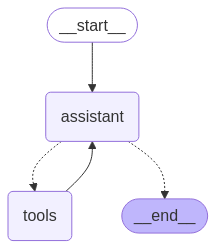

In [12]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [13]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, How are you today?",
    "tell me about this company",
]
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 5872421",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, How are you today?
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (a76a252e-f705-4f72-92dd-205d90a50246)
 Call ID: a76a252e-f705-4f72-92dd-205d90a50246
  Args:
    query: Hello, how can I assist you today?
Loading existing ChromaDB from chroma_store
Loaded collection with 17 documents


/tmp/ipykernel_21089/3482336385.py:27: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'language': 'en-US', 'source': 'https://Mpimanipal.com', 'title': 'Manipal Payment and Identity Solutions'}, page_content='\n\n\n\n\n\n\nManipal Payment and Identity Solutions\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nManipal Payment and Identity Solutions\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n[email\xa0protected]\n\n\n\n\n \n0820 220 5000\n\n\n\n\n\n\n\n\n\n\n\n\n \nContact Us\n\n\n\n\n\n \nCareer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \nCareer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\nMenu\n\n \n\n\nSolutions\n\nProducts\n\nPVC Banking Cards\nIdentity Cards\nMetal Cards\nSmart Wearables\nCheque Printing\n\n\nServices\n\nCard Personalisation\nSmart Packaging\nSecure Logistics\nInstant Issuance\nCCM

================================= Tool Message =================================
Name: lookup_policy

Content:







Manipal Payment and Identity Solutions







































































Manipal Payment and Identity Solutions





 




















 
[email protected]




 
0820 220 5000












 
Contact Us





 
Career

















 






 














 
Career














 










Menu

 


Solutions

Products

PVC Banking Cards
Identity Cards
Metal Cards
Smart Wearables
Cheque Printing


Services

Card Personalisation
Smart Packaging
Secure Logistics
Instant Issuance
CCM




Investor Corner

Financial Performance & Reports
Corporate Governance
Shareholder Pattern
Credit Rating
Prospectus
Other Disclosures, Announcements and Press Release
Investor Contact


Industry

Banking & Financial Services
Government
Insurance
Transport & Transit


About Us

Who We Are
Our Team
News Room


Our Locations

Manufacturing Units
Sales Of

/tmp/ipykernel_21089/3482336385.py:27: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'language': 'en-US', 'source': 'https://Mpimanipal.com', 'title': 'Manipal Payment and Identity Solutions'}, page_content='\n\n\n\n\n\n\nManipal Payment and Identity Solutions\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nManipal Payment and Identity Solutions\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n[email\xa0protected]\n\n\n\n\n \n0820 220 5000\n\n\n\n\n\n\n\n\n\n\n\n\n \nContact Us\n\n\n\n\n\n \nCareer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \nCareer\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\nMenu\n\n \n\n\nSolutions\n\nProducts\n\nPVC Banking Cards\nIdentity Cards\nMetal Cards\nSmart Wearables\nCheque Printing\n\n\nServices\n\nCard Personalisation\nSmart Packaging\nSecure Logistics\nInstant Issuance\nCCM

================================== Ai Message ==================================

Here is a summary of the information provided about Manipal Technologies Limited:

**Overview**

* Integrated Digital Solutions Provider
* Integrated Print-Tech Solutions Provider
* Card Management Solution Provider
* Print Management Solution Provider
* Next-Gen Contactless Wearable Payment Solutions Provider

**History**

* Started in 1941 as Manipal Power Press, offering print services to banks
* Grown into an end-to-end secure print service provider over the years
* Serving customers across the globe with units in all metro cities in India, Kenya, Nigeria, and Germany

**Values**

* To Lead in everything we do by innovating & creating lasting impressions for the development of society

**Team**

* Highly skilled human capital led by a dedicated and motivated management team

**Careers**

* Inviting people who believe in their ability to work on fundamental principles and create new markets for the com